# **Quantum Transfer Learning via Pennylane and ResNet**


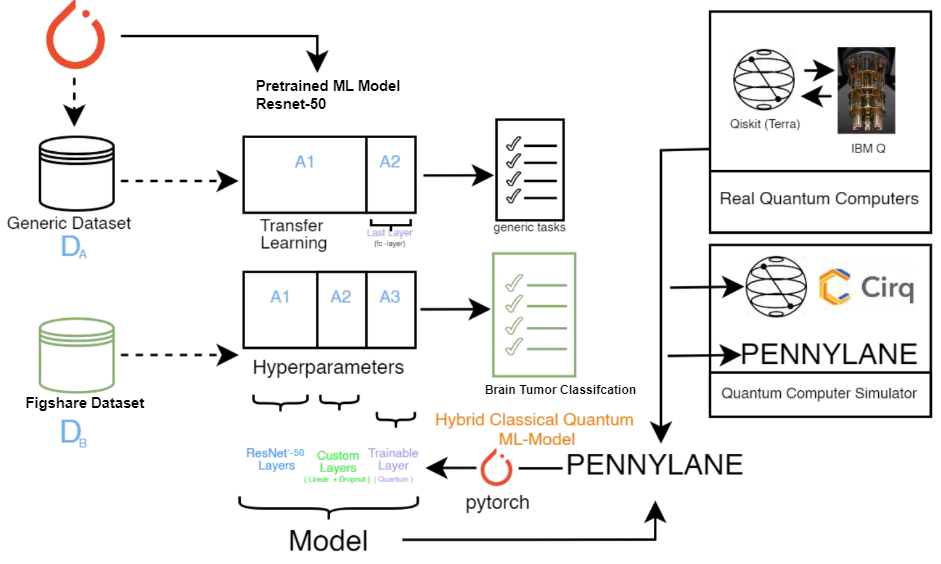



**Importing Dependencies**

In [ ]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt
import cv2

import shutil, os

!pip install split-folders
import splitfolders
import os
import PIL
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2

**Data Preprocessing**

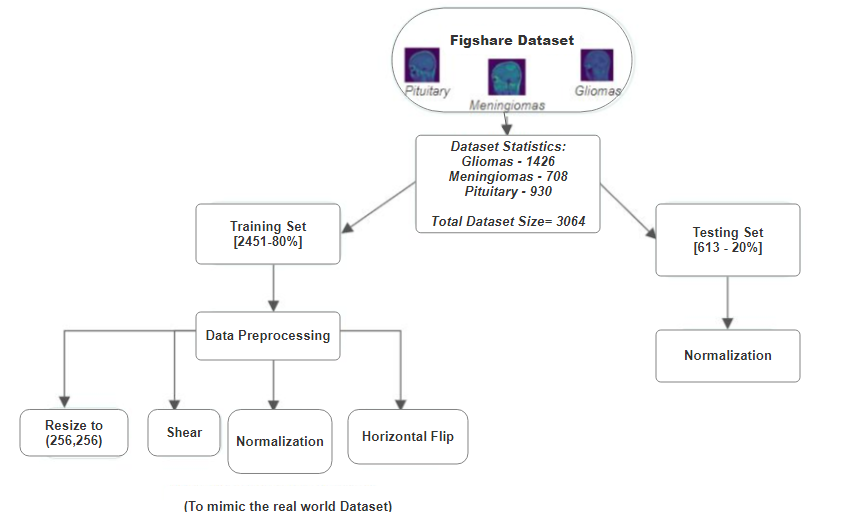

In [ ]:
os.mkdir("/kaggle/working/bt_images")
os.mkdir("/kaggle/working/bt_images/1")
os.mkdir("/kaggle/working/bt_images/2")
os.mkdir("/kaggle/working/bt_images/3")
labels=[]
border=[]
filename = None

for filename in range(1, 3065):
  with h5py.File('/kaggle/input/figshare-brain-tumor-dataset/dataset/data/{}.mat'.format(filename), 'r') as f:
      img = f['cjdata']['image']
      label = f['cjdata']['label'][0][0]
     
     
      labels.append(int(label))
      img = np.array(img, dtype=np.float32)
      
      plt.axis('off')
      
      plt.imsave("/kaggle/working/bt_images/{}/{}.jpg".format(str(int(label)),filename), img, cmap='gray')
      
      
print("{} files successfully saved".format(filename))

!pip install split-folders
import splitfolders
splitfolders.ratio('/kaggle/working/bt_images', output="/kaggle/working/output", seed=10,ratio=(0.8, 0.2)) 

In [ ]:
input_path = "/kaggle/working/output/"

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        #normalize
    ]),
}

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(input_path + 'val', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=1),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=1)  # for Kaggle
}

**Downloading Pennylane and Declaring Hyperparameters**

In [ ]:
#%%capture
# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

import pennylane as qml
from pennylane import numpy as np

In [ ]:
n_qubits = 8                 # Number of qubits
q_depth = 10                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01               # Initial spread of random quantum weights
start_time = time.time()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev = qml.device("default.qubit.torch", wires=n_qubits)  # a simple state simulator of qubit-based quantum circuit architectures provided by pennylane

# **Model Creation**
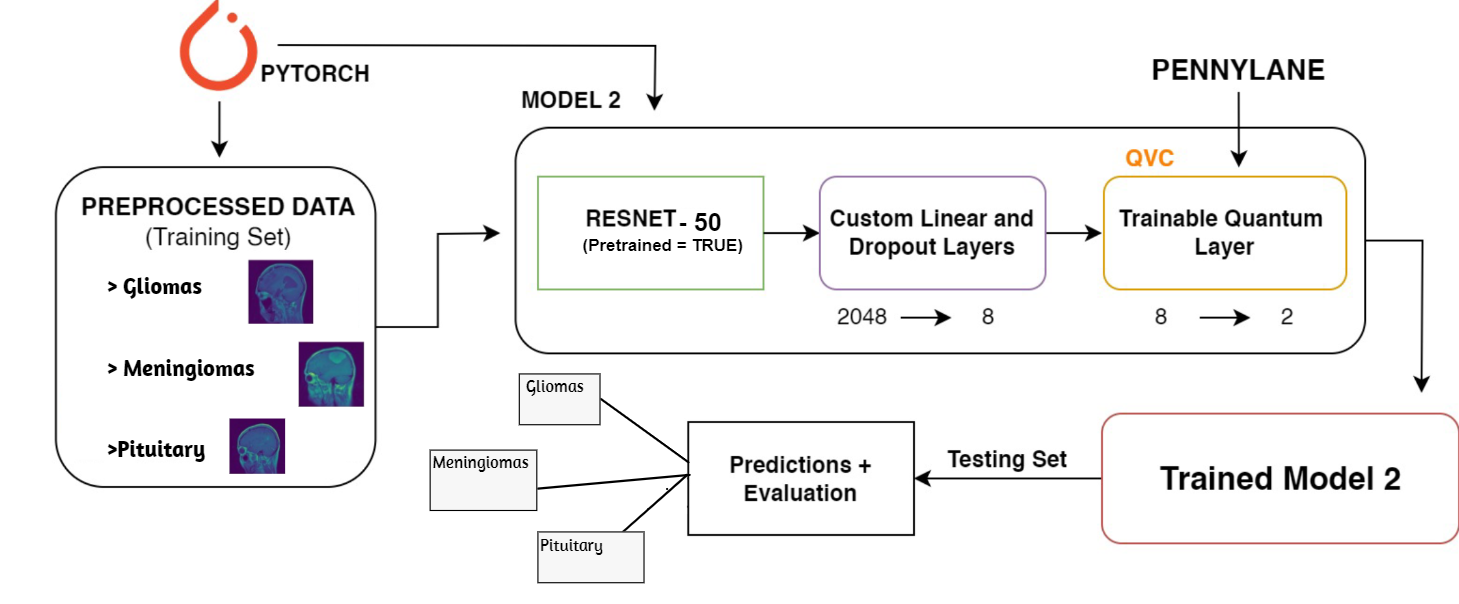

# Quantum Variational Circuit

**Basic Layers for Quantum Circuit**

1. Hadamard Gate. No. of Qubits = 10
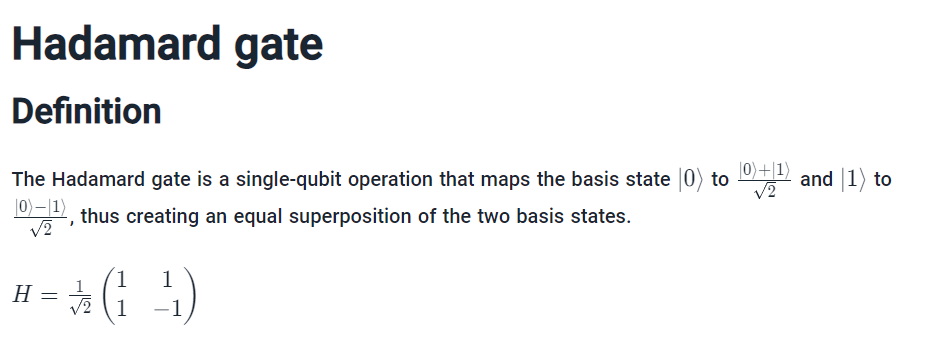

2. Ry Layer
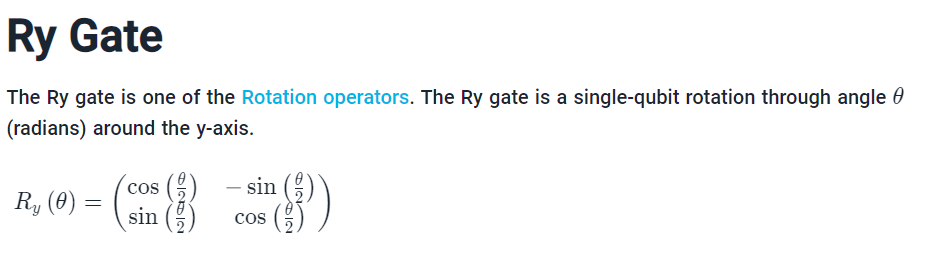

3. Shifted Layer of CNOT Gates
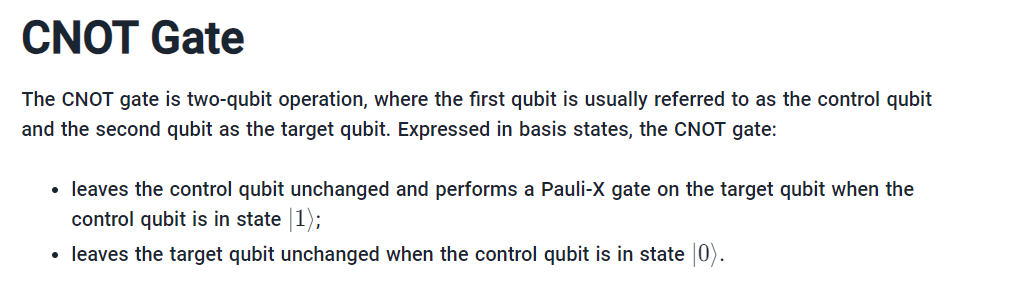

In [ ]:
def H_layer(nqubits):
    """
      Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """
      Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """
      Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])


# PennyLane qnode decorator

The structure is that of a typical variational quantum circuit:

**Embedding layer:** All qubits are first initialized in a balanced superposition of up and down states, then they are rotated according to the input parameters (local embedding).

**Variational layers:** A sequence of trainable rotation layers and constant entangling layers is applied.

**Measurement layer:** For each qubit, the local expectation value of the Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basisT
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


# Dressed quantum circuit

We can now define a custom `torch.nn.Module` representing a dressed quantum circuit.

This is a concatenation of:


*   A classical pre-processing layer (nn.Linear).
*   A classical activation function (torch.tanh).
*   A constant np.pi/2.0 scaling.
*   The previously defined quantum circuit (quantum_net).
*   A classical post-processing layer (nn.Linear).


In [ ]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()

        self.pre_net = nn.Linear(8,n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 3)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            
            q_out_elem = torch.hstack(quantum_net(elem,self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)



# Hybrid Classical-Quantum Model

We are finally ready to build our full hybrid classical-quantum network. We follow the transfer learning approach:




1.   First load the classical pre-trained network ResNet152 from the torchvision.models zoo with Resnet-50 weights.
2. Pretrained is set to False, and so PyTorch will not download the pretrained weights.
3. Add your custom layers to the pre-trained model.
4. Replace the last fully connected layer with our trainable dressed quantum circuit (DressedQuantumNet).









In [ ]:
from torchvision.models import resnet50
model1 = torchvision.models.resnet50(pretrained = True)
# for param in model1.parameters():
#     param.requires_grad = False

n_inputs = model1.fc.in_features
model1.fc = nn.Sequential(
    nn.Linear(n_inputs, 2048),
    nn.ReLU(),
    #nn.Dropout(p=0.2),
    nn.Linear(2048, 512),
    nn.ReLU(),
    #nn.Dropout(p=0.2),
    nn.Linear(512,32),
    nn.ReLU(),
    nn.Linear(32,8),
    DressedQuantumNet()
)
# for name, child in model1.named_children():
#     if name=='layer4':
#         for param in child.parameters():
#             param.requires_grad = True
# model2=model1
#model1.load_state_dict(torch.load('/kaggle/input/modelqtl/pytorch/final/1/model1_final (4).pth'))
# Use CUDA or CPU according to the "device" object.
model1 = model1.to(device)
model1.load_state_dict(torch.load('/kaggle/input/modelqtl/pytorch/train_up/1/modelx_final.pth'))
# # Use CUDA or CPU according to the "device" object.
# model2 = model2.to(device)

# **Model Training**

In [ ]:
test_acc , train_acc, test_loss, train_loss = [], [], [], []

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            if(phase == "train"):
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)

            else:
                test_acc.append(epoch_acc)
                test_loss.append(epoch_loss)

    return model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters())
epochs=50

In [ ]:
model_trained = train_model(model1, criterion, optimizer, num_epochs=epochs)

# **Plotting Accuracy and Loss Graphs**

In [ ]:
te_acc = []

for i in test_acc :
  te_acc.append(i.cpu())

tr_acc = []

for i in train_acc :
  tr_acc.append(i.cpu())


In [ ]:
from IPython.display import clear_output

# Your code that generates output

clear_output()
plt.clf()
import matplotlib.pyplot as plt
epochs = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = tr_acc
train_loss = train_loss
val_acc = te_acc
val_loss = test_loss
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

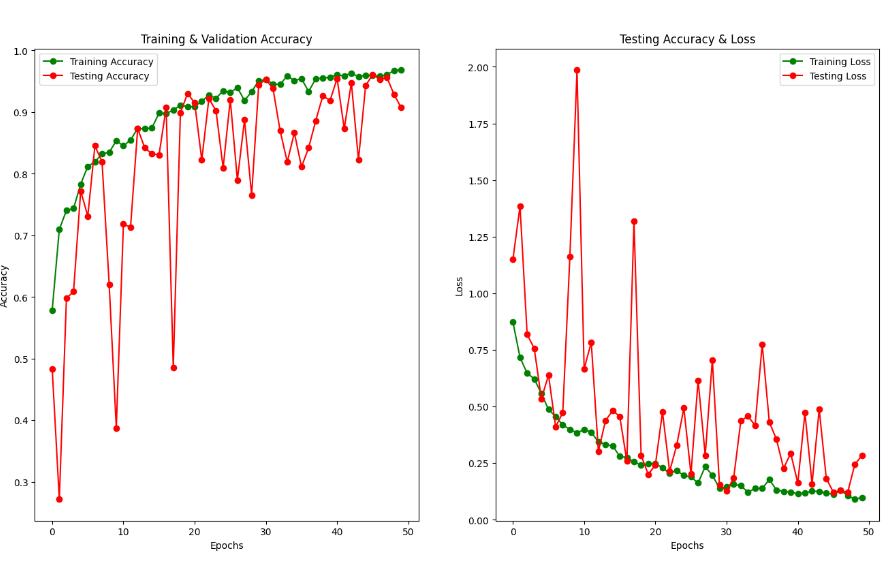

# Saving Model to Drive

In [ ]:
torch.save(model1.state_dict(), 'modelx_final.pth')

# Confusion Matrix and Classification Metrics

In [ ]:
phase = "validation"

y_preds = []
label = []

model1.eval()
for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs1 = model1(inputs)
    loss = criterion(outputs1, labels)

    _, preds = torch.max(outputs1, 1)

    y_preds.append(preds.cpu())
    label.append(labels.cpu())
print(y_preds)
print(labels)

In [ ]:
y_pred = np.array(y_preds[0])
y_true = np.array(label[0])

for i in range(1,len(y_preds)):
  y_pred = np.append(y_pred, np.array(y_preds[i]))

for i in range(1,len(label)):
  y_true = np.append(y_true, np.array(label[i]))

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_true, y_pred)


import seaborn as sns


plt.figure(figsize=(8,6), dpi=100)

sns.set(font_scale = 1.1)

ax = sns.heatmap(cnf, annot=True, fmt='d', )


ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['1' , '2','3'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['1' , '2','3'])

# set plot title
ax.set_title("Confusion Matrix for the Brain Tumor Classification Model", fontsize=14, pad=20)

plt.show()

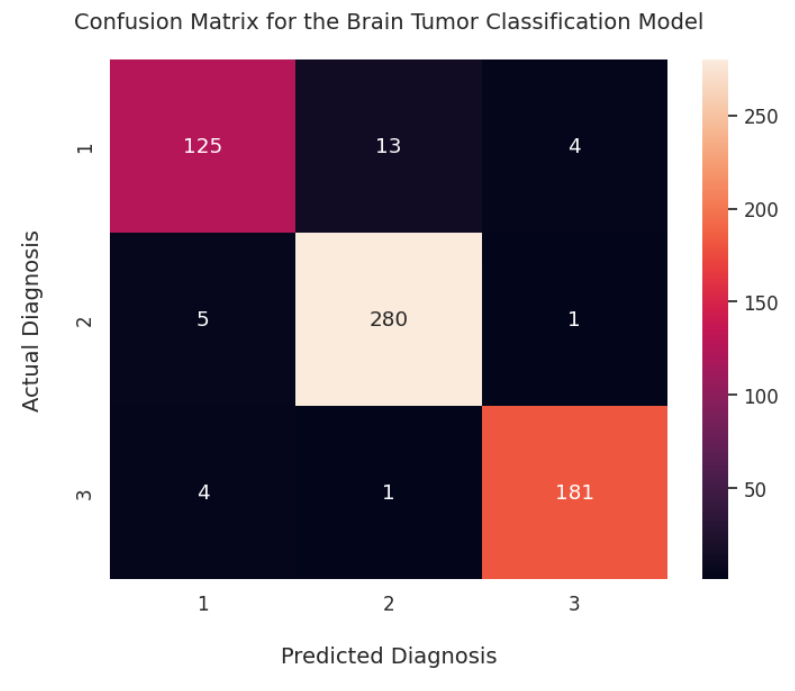

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

classes = ('1' , '2','3')

print(classification_report(y_true, y_pred, target_names=classes))

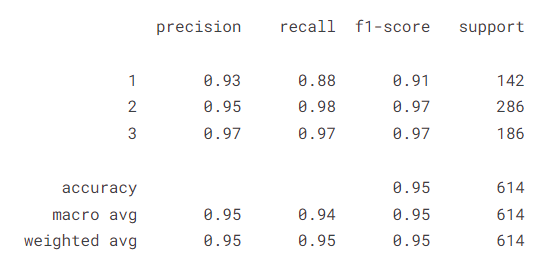